## **MLOPS**

### **Tratamiento de datos**

In [ ]:
# Importamos librerías necesarias
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score, precision_recall_curve
import joblib

def preprocesamiento(data):
  #Cargamos el dataset
  df = data.copy()
  
  #Antes que nada vemos si tenemos una fila completa de valores faltantes
  df.isna().all(axis=1).sum()
  
  #Eliminamos las filas con valores nulos en la variable target
  filas = df[df['RainTomorrow'].isna()].index
  df.drop(filas, inplace=True)
  
  # Eliminamos las columnas 'Evaporation' y 'Sunshine'
  df.drop(columns= ['Evaporation', 'Sunshine'], inplace = True)
  
  #Convertimos el tipo de dato de Date a datetime
  df['Date'] = pd.to_datetime(df['Date'])
  df['Date']
  
  # Agregamos una columna nueva con el mes de cada fecha
  df['Month'] = df['Date'].dt.month
  
  #Quitamos Date del conjunto porque ya no lo necesitamos.
  df.drop(['Date'], axis=1, inplace=True)
  
  X, y = df.drop(columns="RainTomorrow"), df["RainTomorrow"]
  
  # Seleccionamos columnas numéricas y categóricas
  numeric_columns = X.select_dtypes(include=['float64', 'int32', 'int64']).columns
  categorical_columns = X.select_dtypes(include=['object']).columns
  
  # IMPUTACION
  X.drop(columns = 'Location', axis = 1, inplace=True)
  
  X = X.reset_index(drop=True)
  
  # Función auxiliar para determinar si una variable numérica tiene muchos outliers
  def tiene_outliers(serie):
      """
      Determina si una serie numérica tiene muchos outliers.
      El criterio se basa en que si más del 5% de sus valores son outliers,
      la serie posee una gran cantidad de ouliers.
  
      Args:
      serie (pd.Series): La serie numérica a evaluar.
  
      Returns:
      bool: True si la serie tiene muchos outliers, False de lo contrario.
      """
      Q1 = serie.quantile(0.25)
      Q3 = serie.quantile(0.75)
      IQR = Q3 - Q1
      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR
      outliers = serie[(serie < lower_bound) | (serie > upper_bound)]
  
      # Consideramos que tiene muchos outliers si más del 5% de los datos son outliers
      return len(outliers) / len(serie) > 0.05
  
  # Función para aplicar mediana o media a columnas numéricas y moda a las no numéricas
  def imputar_faltantes_por_mes(df, columna_mes, columnas, columnas_numericas, columnas_categoricas):
      """
      Imputa los valores faltantes de las columnas especificadas en un DataFrame agrupando por mes,
      utilizando la mediana, media o moda según el tipo de variable.
  
      Args:
      df (pd.DataFrame): El DataFrame con los datos.
      columna_mes (str): El nombre de la columna que contiene los meses.
      columnas (list): Lista de columnas a imputar.
      columnas_numericas (list): Lista de columnas numéricas.
      columnas_categoricas (list): Lista de columnas categóricas.
  
      Returns:
      pd.DataFrame: DataFrame con las columnas imputadas.
      """
  
      # Imputación por cada columna
      for columna in columnas_categoricas:
          # Imputar con la moda agrupando por mes
          df[columna] = df.groupby(columna_mes)[columna].transform(lambda grupo: grupo.fillna(grupo.mode()[0] if not grupo.mode().empty else np.nan))
  
      for columna in columnas_numericas:
          for mes, grupo in df.groupby(columna_mes):
              if tiene_outliers(grupo[columna].dropna()):  # Si tiene muchos outliers, usar la mediana
                  df.loc[df[columna_mes] == mes, columna] = grupo[columna].fillna(grupo[columna].median())
              else:  # De lo contrario, usar la media
                  df.loc[df[columna_mes] == mes, columna] = grupo[columna].fillna(grupo[columna].mean())
  
      return df
  
  # Aplicamos la función a cada conjunto de datos
  columnas_a_imputar = X.columns[X.isnull().sum() > 0]
  categorical_columns = categorical_columns.drop('Location')
  
  X = imputar_faltantes_por_mes(X, 'Month', columnas_a_imputar, numeric_columns, categorical_columns)
  
  # Quitamos las columnas categóricas mes agregadas para realizar la imputacion
  X.drop(columns = 'Month', axis = 1, inplace=True)
  
  numeric_columns = numeric_columns.drop('Month')
  
  # Codificación de variables categóricas
  
  #Codificación RainToday
  X['RainToday'] = X['RainToday'].map({'Yes': 1,  'No':0})
  
  # Codificación de las variables objetivo (y, y_test, y_val)
  y = np.where(y == 'Yes', 1, 0)
  
  def num_dir(df, n):
    """Recibe un dataframe y un numero de direcciones de viento
    y reemplaza en las columnas correspondientes a direcciones de viento
    segun sea el n"""
    data = df.copy(deep=True)
    cols = data.select_dtypes(include=['object']).columns
    if n == 4:
      data[cols] = data[cols].replace(['NW','NNE','NE','NNW'], 'N')
      data[cols] = data[cols].replace(['WNW','WSW'], 'W')
      data[cols] = data[cols].replace(['ENE','ESE'], 'E')
      data[cols] = data[cols].replace(['SW','SSW','SE','SSE'], 'S')
    elif n == 8:
      data[cols] = data[cols].replace(['NNE','NNW'], 'N')
      data[cols] = data[cols].replace(['WNW','WSW'], 'W')
      data[cols] = data[cols].replace(['ENE','ESE'], 'E')
      data[cols] = data[cols].replace(['SSW','SSE'], 'S')
    return data
  
  #Modificamos las direcciones de viento para cada conjunto
  #para tener 4 direcciones en vez de 16
  X = num_dir(X, 4)
  
  #Utilizamos el metodo get_dummies para hacer un one hot encoding estandar
  X = pd.get_dummies(X, prefix_sep='_', dtype=int)
  
  # Creamos el escalador
  scaler = RobustScaler()
  
  # Aplicamos el escalado solo a las columnas numéricas
  X[numeric_columns] = scaler.fit_transform(X[numeric_columns])
  
  return X, y

### **Modelo**

In [10]:
# ELEGIR MODELO FINAL A UTILIZAR, ENTRENARLO Y GUARDARLO
# Entrenar el modelo de regresión logística
model = LogisticRegression(class_weight="balanced", #ajusta automaticamente los pesos de las clases
                           solver = 'lbfgs',
                           max_iter=360, #Menor a esto no converge!
                           random_state=42)

# Entrenamiento
data = pd.read_csv("files/train.csv")
X_train, y_train = preprocesamiento(data)
model.fit(X_train, y_train.ravel())

LogisticRegression(class_weight='balanced', max_iter=360, random_state=42)

In [11]:
# Guardado
joblib.dump(model, "./docker/model.pkl")
print("> Modelo de clasificacion guardado con exito")

> Modelo de clasificacion guardado con exito


### **Metricas**

                precision    recall  f1-score   support

Clase Negativa     0.9508    0.8111    0.8754      3552
Clase Positiva     0.4558    0.7904    0.5782       711

      accuracy                         0.8076      4263
     macro avg     0.7033    0.8008    0.7268      4263
  weighted avg     0.8683    0.8076    0.8258      4263



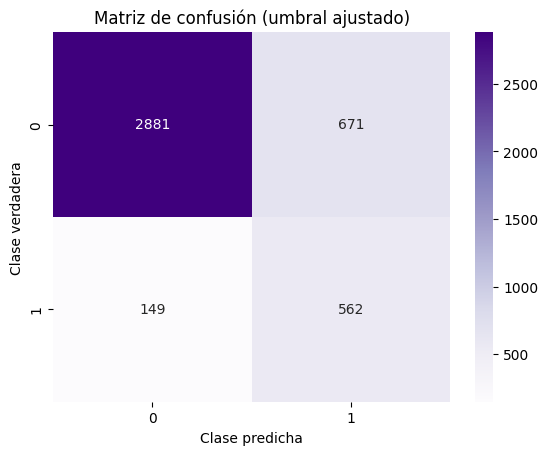

In [12]:
import matplotlib.pyplot as plt
import joblib

# Cargamos el modelo
model = joblib.load("./docker/model.pkl")

# Cargamos los datos de test
data = pd.read_csv("files/test.csv")
X_test, y_test = preprocesamiento(data)

# Predicciones
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
report = classification_report(y_test, y_pred, target_names=["Clase Negativa", "Clase Positiva"], digits=4)
print(report)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples")
plt.xlabel("Clase predicha")
plt.ylabel("Clase verdadera")
plt.title("Matriz de confusión (umbral ajustado)")
plt.show()



### **Docker**

In [ ]:
!docker build -t inference-python-test ./dockerfile

!docker run -it --rm --name inference-python-test -v ./files:/files inference-python-test

/bin/bash: line 1: docker: command not found


**Check docker output**

In [6]:
import pandas as pd

df_output = pd.read_csv("./files/output.csv")
df_output.value_counts()

RainTomorrow
0               713
1               287
Name: count, dtype: int64